In [57]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [58]:
#########################################
# Function: load_data
# Loads train and store data from CSV files.
#########################################
def load_data(train_path='train.csv', store_path='store.csv'):
    """
    Loads the Rossmann train and store datasets.
    Args:
      train_path (str): Path to train.csv file.
      store_path (str): Path to store.csv file.
    Returns:
      train (DataFrame): Training dataset.
      store (DataFrame): Store-specific data.
    """
    train = pd.read_csv(train_path, parse_dates=['Date'])
    store = pd.read_csv(store_path)
    return train, store

In [59]:
#########################################
# Function: merge_data
# Merge train and store data on Store ID.
#########################################
def merge_data(train, store):
    """
    Merge the train dataset with the store dataset on the 'Store' column.
    Args:
      train (DataFrame): Training dataset.
      store (DataFrame): Store-specific dataset.
    Returns:
      df (DataFrame): Merged dataset.
    """
    df = pd.merge(train, store, on='Store', how='left')
    return df

In [60]:
#########################################
# Function: preprocess_data
# Basic cleaning: filter out closed stores and fill missing values.
#########################################
def preprocess_data(df):
    """
    Preprocess the merged dataframe.
      - Remove rows where Sales are 0 (closed stores or irrelevant days).
      - Fill missing values for numeric columns.
    Args:
      df (DataFrame): Merged dataset.
    Returns:
      df (DataFrame): Cleaned dataset.
    """
    # Remove records with zero sales (stores closed or non-operational days)
    if 'Sales' in df.columns:
      df = df[df['Sales'] > 0].copy()

    # Fill missing CompetitionDistance with a large number (indicating far competitor)
    df['CompetitionDistance'].fillna(df['CompetitionDistance'].max(), inplace=True)

    # Fill missing values in competition open columns with the corresponding year or month from Date
    df['CompetitionOpenSinceYear'].fillna(df['Date'].dt.year, inplace=True)
    df['CompetitionOpenSinceMonth'].fillna(df['Date'].dt.month, inplace=True)

    # Fill missing Promo2 related values with 0
    df['Promo2SinceWeek'].fillna(0, inplace=True)
    df['Promo2SinceYear'].fillna(0, inplace=True)
    df['PromoInterval'].fillna("None", inplace=True)

    return df

In [61]:
#########################################
# Function: feature_engineering
# Create new features from the Date column and others.
#########################################
def feature_engineering(df):
    """
    Create new features to enrich the dataset.
      - Extract Year, Month, Day, WeekOfYear, DayOfWeek from Date.
      - Create a binary indicator for weekend.
      - Compute competition open since (combine year and month).
      - Create feature indicating time since last promo2 (if applicable).
      - Encode categorical variables.
    Args:
      df (DataFrame): Preprocessed dataframe.
    Returns:
      df (DataFrame): DataFrame with new engineered features.
    """
    # Date features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x>=5 else 0)

    # Competition open since: combine year and month into a single numeric value
    # (e.g. 2008 and 9 becomes 200809)
    df['CompetitionOpenSince'] = df['CompetitionOpenSinceYear'].astype(int)*100 + df['CompetitionOpenSinceMonth'].astype(int)

    # Promo2 duration: months since promo2 started (if promo2 is active)
    # For rows where Promo2 == 1, calculate how many months promo2 has been running
    df['Promo2SinceYear'] = df['Promo2SinceYear'].astype(int)
    df['Promo2SinceWeek'] = df['Promo2SinceWeek'].astype(int)
    df['Promo2Active'] = df['Promo2'].apply(lambda x: 1 if x == 1 else 0)
    # Calculate approximate months since promo2 started (we use year and month difference)
    df['Promo2Since'] = df.apply(lambda row: (row['Year'] - row['Promo2SinceYear']) * 12 + (row['Month'] - (row['Promo2SinceWeek'] // 4 + 1))
                                 if row['Promo2Active'] == 1 and row['Promo2SinceYear'] > 0 else 0, axis=1)

    if 'Sales' in df.columns:
      # Log-transform the target variable "Sales" to stabilize variance
      df['LogSales'] = np.log1p(df['Sales'])

    # Encode categorical features using one-hot encoding:
    # - StateHoliday, StoreType, and Assortment are categorical.
    df = pd.get_dummies(df, columns=['StateHoliday', 'StoreType', 'Assortment'], drop_first=True)

    return df

In [62]:
#########################################
# Function: eda
# Generate sensible plots to explore the data.
#########################################
def eda(df):
    """
    Perform Exploratory Data Analysis:
      - Plot distribution of Sales.
      - Plot time series of Sales for a sample store.
      - Plot correlation heatmap.
    Args:
      df (DataFrame): DataFrame after feature engineering.
    """
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Sales'], bins=50, kde=True)
    plt.title("Distribution of Sales")
    plt.xlabel("Sales")
    plt.ylabel("Frequency")
    plt.show()

    # Time-series plot for a sample store (store 1)
    store1 = df[df['Store'] == 1].sort_values(by='Date')
    plt.figure(figsize=(12, 5))
    plt.plot(store1['Date'], store1['Sales'], marker='o', linestyle='-', markersize=3)
    plt.title("Store 1 Sales Over Time")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Correlation heatmap of numerical features
    plt.figure(figsize=(12, 10))
    numeric_cols = df.select_dtypes(include=['int64','float64']).columns
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Correlation Heatmap")
    plt.show()

In [63]:
#########################################
# Function: train_model
# Train XGBoost model with hyperparameter tuning.
#########################################
def train_model(X_train, y_train):
    """
    Train an XGBoost regressor using GridSearchCV for hyperparameter tuning.
    Args:
      X_train (DataFrame): Training features.
      y_train (Series): Target variable.
    Returns:
      best_model: Fitted XGBoost model with the best parameters.
    """
    # Define the model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Parameter grid for tuning (feel free to adjust)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # Use GridSearchCV for hyperparameter tuning
    grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                        scoring='neg_root_mean_squared_error', cv=3, verbose=1)
    grid.fit(X_train, y_train)
    print("Best parameters found: ", grid.best_params_)
    print("Best RMSE (negative): ", grid.best_score_)
    best_model = grid.best_estimator_
    return best_model

In [64]:
#########################################
# Function: evaluate_model
# Predict on test data and evaluate using RMSE, MAE, MAPE. Also, plot predicted vs actual.
#########################################
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model using RMSE, MAE, and MAPE.
    Plot a comparison of predicted vs actual Sales.
    Args:
      model: Trained model.
      X_test (DataFrame): Test features.
      y_test (Series): Test target values.
    """
    predictions = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

    print("Evaluation Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Plot actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
    plt.xlabel("Actual Log Sales")
    plt.ylabel("Predicted Log Sales")
    plt.title("Actual vs. Predicted Log Sales")
    plt.show()

In [65]:
#########################################
# Main function to run the full pipeline.
#########################################
def main():
    """
    Main execution function.
    1. Load and merge data.
    2. Preprocess and feature engineer.
    3. Perform EDA (plots).
    4. Prepare data for modeling.
    5. Train XGBoost model with hyperparameter tuning.
    6. Evaluate model performance.
    """
    # 1. Load data (ensure train.csv and store.csv are in your working directory)
    train, store = load_data()
    print("Train and Store data loaded.")

    # 2. Merge train and store data
    df = merge_data(train, store)
    print("Data merged. Shape:", df.shape)

    # 3. Preprocess the data
    df = preprocess_data(df)
    print("Data preprocessed. Shape:", df.shape)

    # 4. Feature engineering
    df = feature_engineering(df)
    print("Feature engineering completed. New shape:", df.shape)

    # 5. Exploratory Data Analysis (EDA)
    print("Starting EDA...")
    eda(df)

    # 6. Prepare data for modeling
    # We use the engineered features and drop columns that are not needed.
    # For modeling, we will predict the log-transformed sales ("LogSales")
    drop_cols = ['Id', 'Sales', 'Date', 'LogSales', 'Customers']  # 'LogSales' is our target; 'Id' is not needed
    # Keep all numeric features; if there are any remaining non-numeric columns, drop them.
    features = df.drop(columns=drop_cols, errors='ignore')

    # Ensure that the features are all numeric
    features = features.select_dtypes(include=[np.number])

    X = features
    y = df['LogSales']  # we predict log sales

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Data split into training and testing sets.")

    # 7. Train the model
    print("Training the XGBoost model...")
    model = train_model(X_train, y_train)

    # 8. Evaluate the model
    print("Evaluating the model...")
    evaluate_model(model, X_test, y_test)

    model.save_model('xgb_rossmann_model.json')
    print("Model saved to xgb_rossmann_model.json")

    # # Evaluate on the external test set from test.csv
    # print("Evaluating model on external test.csv...")
    # evaluate_external_test(model, test_csv_path='test.csv', store_csv_path='store.csv')

    print("Pipeline completed.")

Train and Store data loaded.
Data merged. Shape: (1017209, 18)
Data preprocessed. Shape: (844338, 18)
Feature engineering completed. New shape: (844338, 33)
Starting EDA...


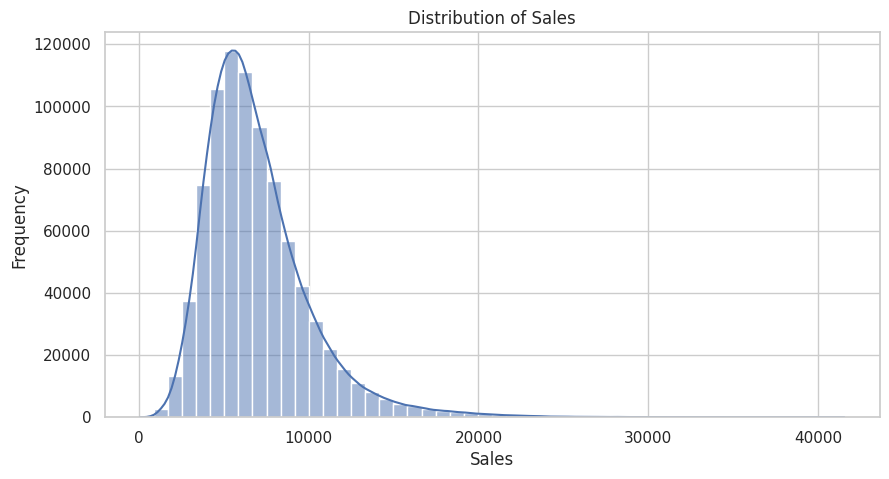

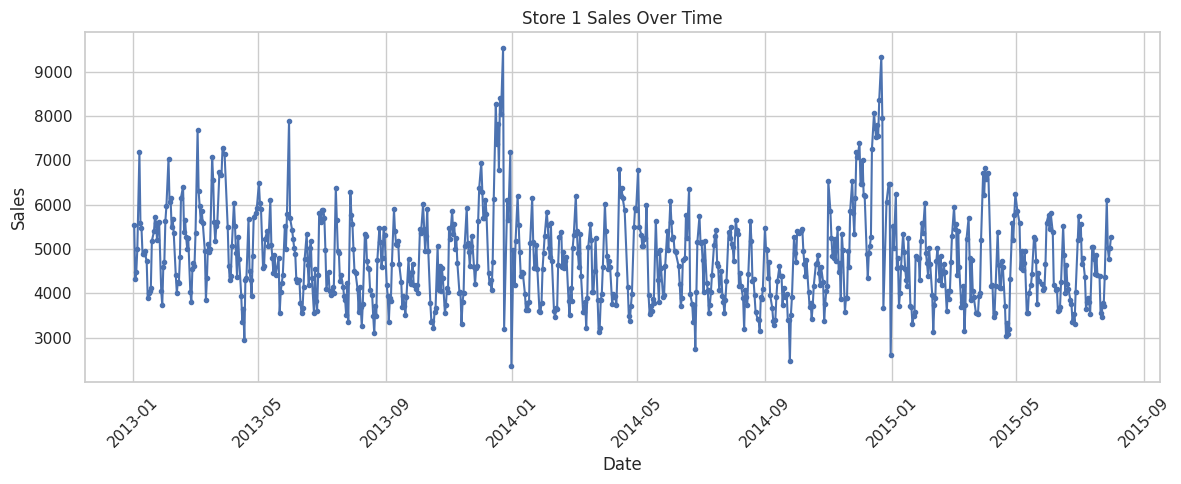

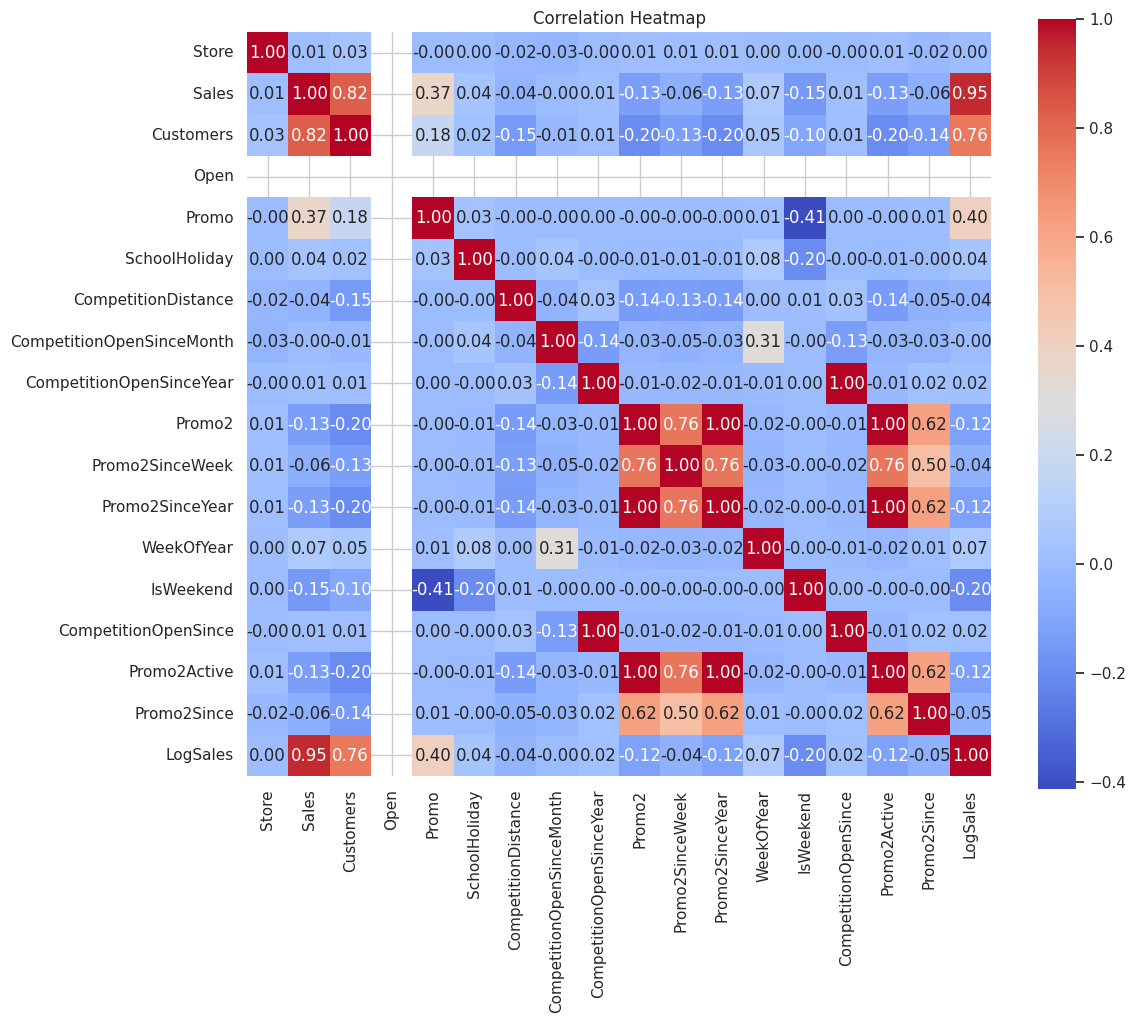

Data split into training and testing sets.
Training the XGBoost model...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best RMSE (negative):  -0.23662582005496624
Evaluating the model...
Evaluation Metrics:
RMSE: 0.24
MAE: 0.18
MAPE: 2.08%


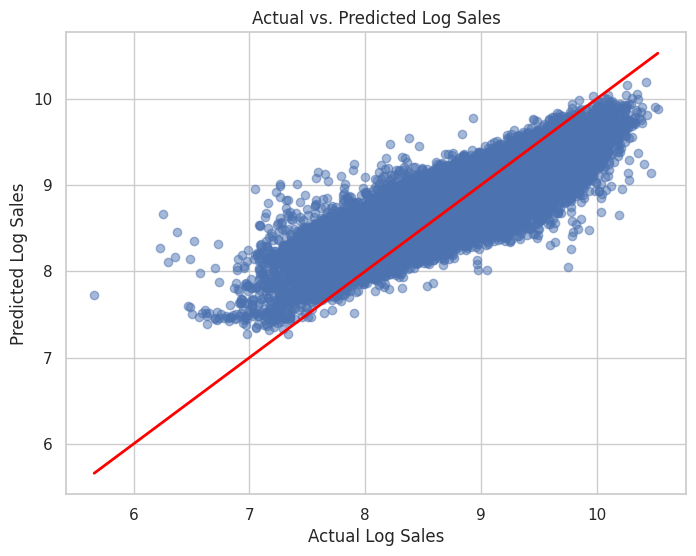

Model saved to xgb_rossmann_model.json
Pipeline completed.


In [66]:
#########################################
# Execute main function
#########################################
# if __name__ == '__main__':
#     main()

main()

In [67]:
def load_and_evaluate_external():
    """
    Loads a previously trained XGBoost model and evaluates it on external test set.
    """
    # Load model
    model = xgb.XGBRegressor()
    model.load_model('xgb_rossmann_model.json')
    print("Model loaded from xgb_rossmann_model.json")
    return model

In [70]:
model = load_and_evaluate_external()

Model loaded from xgb_rossmann_model.json


In [84]:
def evaluate_test_data(model, merged_test_df):
    """
    Evaluates the external test dataframe (already merged with store data)
    using the trained model.

    This function applies the same preprocessing and feature engineering steps
    as used in training. It then drops columns that are not used for prediction
    (including 'Customers', since it is not available in future data) and returns
    model predictions.

    Args:
      model: Trained XGBoost model.
      merged_test_df (DataFrame): Merged test data (test.csv merged with store.csv).

    Returns:
      preds (ndarray): Model predictions.
    """
    # Apply the same preprocessing and feature engineering
    test_clean = preprocess_data(merged_test_df)
    test_fe = feature_engineering(test_clean)

    # Build the list of columns to drop from test data;
    # note: we drop 'Id', 'Date', 'Sales', 'LogSales', and importantly 'Customers'
    drop_cols = ['Id', 'Sales', 'Date', 'LogSales', 'Customers']
    X_test = test_fe.drop(columns=[col for col in drop_cols if col in test_fe.columns], errors='ignore')

    # Ensure only numeric features are used (and the order of columns matches training)
    X_test = X_test.select_dtypes(include=[np.number])

    # Get predictions from the model
    preds = model.predict(X_test)

    predictions = model.predict(X_test)
    return preds

In [85]:
print("Loading and merging external test data...")
test_df = pd.read_csv('test.csv', parse_dates=['Date'])
store = pd.read_csv('store.csv')
external_merged = pd.merge(test_df, store, on='Store', how='left')

Loading and merging external test data...


In [90]:
print("Evaluating external test data...")
evaluate_test_data(model, external_merged)

Evaluating external test data...


array([8.600983 , 8.89819  , 9.131029 , ..., 8.76142  , 9.797814 ,
       8.5191345], dtype=float32)

In [91]:
# prompt: create submission.csv with the same formatting as sample_submission using the pred array returned from the evaluate_test_data function from the last cell

import pandas as pd
import numpy as np

# Assuming 'evaluate_test_data' and 'external_merged' are defined from the previous cell
pred = evaluate_test_data(model, external_merged)

# Create a DataFrame for submission
submission_df = pd.DataFrame({'Id': external_merged['Id'], 'Sales': np.expm1(pred)})

# Save to submission.csv
submission_df.to_csv('submission.csv', index=False)
